## 1. Import and Install Dependencies

In [1]:
#Copy API key from Materials Project and use it to access datasets.
Keerthana_API = "(insert api here)"

#Import the needed libraries and modules.
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import sys
sys.path.append("C:\\Users\\Keerthana\\pymatgen\\src\\pymatgen")#Pymatgen needs to be downloaded and appended with SYS before being used.
import pymatgen.core as mat 

#MPRester is an easier way of using the requests package. 
#It is able to directly interact with Materials Project data using HTTP connection pooling.
from pymatgen.ext.matproj import MPRester

## 2. Set Up X and Y Values

In [2]:
#Plot data within Jupyter Notebook.
%matplotlib inline

#Set the x and y values. 
with MPRester(Keerthana_API) as mpr:
    structures = []
    c_energy = []
    
    def insert_value(arr, index, value):
        arr.insert(index, value)
    
    x_index = 0
    x_value = ''
    y_index = 0
    y_value = ''
    
    elements = ['H', 'O', 'C']
    
    for element in elements:
        for id in mpr.get_materials_ids(element):
            x_value = mpr.get_structure_by_material_id(id)
            y_value = mpr.get_cohesive_energy(id)
            insert_value(structures, x_index, x_value)
            insert_value(c_energy, y_index, y_value)
            x_index = x_index + 1
            y_index = y_index + 1

C:\Users\Keerthana\pymatgen\src\pymatgen\pymatgen\ext\matproj.py:186: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


In [4]:
print(f"This is x: {structures}")
print(f"This is y: {c_energy}")

This is x: [Structure Summary
Lattice
    abc : 4.697337 4.955131 5.477365
 angles : 90.0 90.0 90.0
 volume : 127.49071057039504
      A : 4.697337 0.0 0.0
      B : 0.0 4.955131 0.0
      C : 0.0 0.0 5.477365
    pbc : True True True
PeriodicSite: H (2.422, 1.866, 4.108) [0.5155, 0.3766, 0.75]
PeriodicSite: H (4.624, 4.344, 4.108) [0.9845, 0.8766, 0.75]
PeriodicSite: H (2.276, 3.089, 1.369) [0.4844, 0.6234, 0.25]
PeriodicSite: H (0.07304, 0.6113, 1.369) [0.01555, 0.1234, 0.25]
PeriodicSite: H (2.148, 2.558, 4.108) [0.4572, 0.5162, 0.75]
PeriodicSite: H (0.201, 0.08033, 4.108) [0.04278, 0.01621, 0.75]
PeriodicSite: H (2.55, 2.397, 1.369) [0.5428, 0.4838, 0.25]
PeriodicSite: H (4.496, 4.875, 1.369) [0.9572, 0.9838, 0.25]
PeriodicSite: H (4.448, 2.335, 5.239) [0.9468, 0.4712, 0.9565]
PeriodicSite: H (2.598, 4.813, 2.977) [0.5532, 0.9712, 0.5435]
PeriodicSite: H (0.2498, 2.62, 2.5) [0.05318, 0.5288, 0.4565]
PeriodicSite: H (2.099, 0.1425, 0.2384) [0.4468, 0.02876, 0.04353]
PeriodicSite: H

## 3. Dimensionality Reduction and Setting Up The Data Frame

The x values for structural properties have high dimensionality, making it challenging to plot for linear regression. Using dimensionality reduction, we can retain important information while making the data more usable. 

In [5]:
x = [] #Numpy Array
x_feature_matrix = [] #Where the feature vectors will initially be placed

#Need to make sure that the feature vectors for elements are completed in steps (first hydrogen, then carbon, then oxygen)
for element in elements:
    for structure in structures:
            #Feature vector contains data on the points and angles of the lattice structure
            feature_vector = [
                structure.lattice.a,
                structure.lattice.b,
                structure.lattice.c,
                structure.lattice.alpha, 
                structure.lattice.beta, 
                structure.lattice.gamma
            ]
            x_feature_matrix.append(feature_vector)
    
x = np.array(x_feature_matrix)

#Standardize the data
scaler = StandardScaler()
x_standard = scaler.fit_transform(x)

In [6]:
print(x_standard)
x_standard.shape

[[-0.16296121 -0.13172415 -0.40755336  0.24513615  0.22086464 -0.06888014]
 [-0.2586709   0.17652592  0.37954942  0.24513615  0.22086464 -0.06888014]
 [-0.63498758 -0.66026768 -0.83580157  1.06907732  1.04329656  0.66565006]
 ...
 [-0.82016538 -0.83886592  3.25234265  0.24513615  0.22086464  0.90950906]
 [-0.80299061 -0.35788862  0.23888952  0.24513615  0.22086464 -0.06888014]
 [ 0.74059571  0.66643969  0.00341747  1.13803901  1.11213192  0.56613422]]


(285, 6)

In [7]:
#Reduce the 6 dimensions of the data to 1 dimension
pca = PCA(n_components = 2)
pca.fit(x_standard)
x_pca = pca.transform(x_standard)
x_pca = pd.DataFrame(x_pca, columns=['properties', 'angles'])
x_pca.head()


properties    angles
0   -0.391105 -0.181732
1   -0.149769  0.322704
2   -1.960293  0.013699
3    0.264811  0.556453
4   -1.441012 -0.697856

In [8]:
#Make sure 
c_energy = np.repeat(c_energy, 3)
print(c_energy)

[ 4.48305745e+00  4.48305745e+00  4.48305745e+00  4.54635097e+00
  4.54635097e+00  4.54635097e+00  4.54663563e+00  4.54663563e+00
  4.54663563e+00  4.54508926e+00  4.54508926e+00  4.54508926e+00
  4.44876419e+00  4.44876419e+00  4.44876419e+00  1.11561200e-02
  1.11561200e-02  1.11561200e-02  3.06452000e-03  3.06452000e-03
  3.06452000e-03  4.51964224e+00  4.51964224e+00  4.51964224e+00
  4.55092378e+00  4.55092378e+00  4.55092378e+00  4.54688067e+00
  4.54688067e+00  4.54688067e+00 -7.63260000e-03 -7.63260000e-03
 -7.63260000e-03  4.55240828e+00  4.55240828e+00  4.55240828e+00
  3.79564616e+00  3.79564616e+00  3.79564616e+00  2.11620000e-04
  2.11620000e-04  2.11620000e-04  2.16786785e+00  2.16786785e+00
  2.16786785e+00  4.55367576e+00  4.55367576e+00  4.55367576e+00
  3.78445004e+00  3.78445004e+00  3.78445004e+00  6.80481766e+00
  6.80481766e+00  6.80481766e+00  6.45749263e+00  6.45749263e+00
  6.45749263e+00  3.68764775e+00  3.68764775e+00  3.68764775e+00
  5.85974116e+00  5.85974

In [9]:
#Create the data frame
df = pd.DataFrame({'points':x_pca['properties'], 'angles': x_pca['angles'], 'c_energy':c_energy})
df.head()

points    angles  c_energy
0 -0.391105 -0.181732  4.483057
1 -0.149769  0.322704  4.483057
2 -1.960293  0.013699  4.483057
3  0.264811  0.556453  4.546351
4 -1.441012 -0.697856  4.546351

## 4. Make Observations On The Data

<Axes: xlabel='points', ylabel='c_energy'>

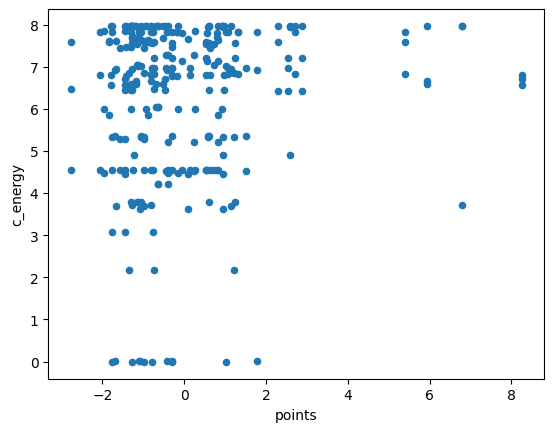

In [10]:
#Make a scatter plot
df.plot.scatter(x = 'points', y = 'c_energy')

<Axes: >

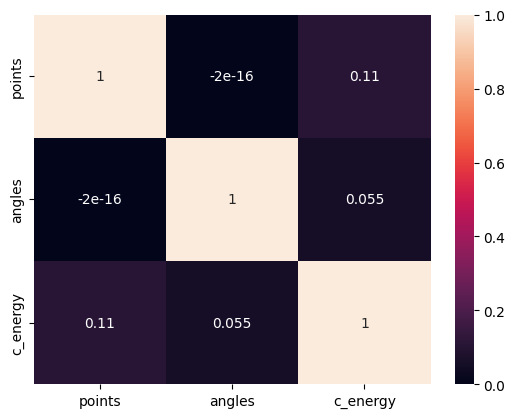

In [11]:
#Make a heat map to observe correlations
sns.heatmap(df.corr(), annot=True)

## 5. Export Data

In [16]:
#Export data as a CSV file
df.to_csv('structure-c_energy.csv', index=False)